In [1]:
import sys
sys.path.append('../utils')
import warnings
warnings.filterwarnings('ignore')

import os
import time 
import copy 
import re

from sklearn import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 

import model_functions
import model_utils
import plotting_utils
import scoring_utils

In [2]:
internet_data_dir = '../data/internet/'
ndhs_data_dir = '../data/ndhs/'
ntl_data_dir = '../data/nightlights/'

dhs_indicators_path = ndhs_data_dir + 'dhs_indicators.csv'
ntl_summary_stats_path = ntl_data_dir + 'nightlights_summary_stats.csv'

fixed_dlspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_fixed download_speeds_summary_stats.csv'
fixed_ulspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_fixed upload_speeds_summary_stats.csv'
fixed_latency_summary_stats_path = internet_data_dir + 'summary_stats/imputed_fixed latency_summary_stats.csv'
mobile_dlspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_mobile download_speeds_summary_stats.csv'
mobile_ulspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_mobile upload_speeds_summary_stats.csv'
mobile_latency_summary_stats_path = internet_data_dir + 'summary_stats/imputed_mobile latency_summary_stats.csv'

In [3]:
osm_roads_file = '../data/osm/osm_roads.csv'
osm_buildings_file = '../data/osm/osm_buildings.csv'
osm_pois_file = '../data/osm/osm_pois.csv'

roads = pd.read_csv(osm_roads_file)
buildings = pd.read_csv(osm_buildings_file)
pois = pd.read_csv(osm_pois_file)

road_cols = roads.columns[1:]
building_cols = buildings.columns[1:]
poi_cols = pois.columns[1:]

osm_cols = list(road_cols) + list(building_cols) + list(poi_cols)

osm = roads.merge(buildings, on='DHSCLUST')
osm = osm.merge(pois, on='DHSCLUST')

In [4]:
fixed_dlspeed_summary_stats = pd.read_csv(fixed_dlspeed_summary_stats_path).drop('Unnamed: 0', 1)
fixed_ulspeed_summary_stats = pd.read_csv(fixed_ulspeed_summary_stats_path).drop('Unnamed: 0', 1)
fixed_latency_summary_stats = pd.read_csv(fixed_latency_summary_stats_path).drop('Unnamed: 0', 1)
mobile_dlspeed_summary_stats = pd.read_csv(mobile_dlspeed_summary_stats_path).drop('Unnamed: 0', 1)
mobile_ulspeed_summary_stats = pd.read_csv(mobile_ulspeed_summary_stats_path).drop('Unnamed: 0', 1)
mobile_latency_summary_stats = pd.read_csv(mobile_latency_summary_stats_path).drop('Unnamed: 0', 1)
ntl_summary_stats = pd.read_csv(ntl_summary_stats_path)

dhs_indicators = pd.read_csv(dhs_indicators_path)
dlspeeds = fixed_dlspeed_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')
ulspeeds = fixed_ulspeed_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')
latency = fixed_latency_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')


# Define feature columns
ntl_summary_stats.columns = ['DHSCLUST', 'ntl_cov', 'ntl_kurtosis', 'ntl_max', 'ntl_mean', 'ntl_median','ntl_min', 'ntl_skewness', 'ntl_std']
feature_cols_fixed_dl = ['fixed_dl_Mean', 'fixed_dl_Maximum', 'fixed_dl_Minimum', 'fixed_dl_Standard Deviation', 'fixed_dl_Median', 'fixed_dl_Skew', 'fixed_dl_Coefficient of Variation', 'fixed_dl_Kurtosis']
feature_cols_fixed_ul = ['fixed_ul_Mean', 'fixed_ul_Maximum', 'fixed_ul_Minimum', 'fixed_ul_Standard Deviation', 'fixed_ul_Median', 'fixed_ul_Skew', 'fixed_ul_Coefficient of Variation', 'fixed_ul_Kurtosis']
feature_cols_fixed_lat = ['fixed_lat_Mean', 'fixed_lat_Maximum', 'fixed_lat_Minimum', 'fixed_lat_Standard Deviation', 'fixed_lat_Median', 'fixed_lat_Skew', 'fixed_lat_Coefficient of Variation', 'fixed_lat_Kurtosis']
feature_cols_mobile_dl = ['mobile_dl_Mean', 'mobile_dl_Maximum', 'mobile_dl_Minimum', 'mobile_dl_Standard Deviation', 'mobile_dl_Median', 'mobile_dl_Skew', 'mobile_dl_Coefficient of Variation', 'mobile_dl_Kurtosis']
feature_cols_mobile_ul = ['mobile_ul_Mean', 'mobile_ul_Maximum', 'mobile_ul_Minimum', 'mobile_ul_Standard Deviation', 'mobile_ul_Median', 'mobile_ul_Skew', 'mobile_ul_Coefficient of Variation', 'mobile_ul_Kurtosis']
feature_cols_mobile_lat = ['mobile_lat_Mean', 'mobile_lat_Maximum', 'mobile_lat_Minimum', 'mobile_lat_Standard Deviation', 'mobile_lat_Median', 'mobile_lat_Skew', 'mobile_lat_Coefficient of Variation', 'mobile_lat_Kurtosis']
feature_cols_nightlights = ['ntl_cov', 'ntl_kurtosis', 'ntl_max', 'ntl_mean', 'ntl_median','ntl_min', 'ntl_skewness', 'ntl_std']

feature_cols_fixednet = feature_cols_fixed_dl + feature_cols_fixed_ul + feature_cols_fixed_lat
feature_cols_mobilenet = feature_cols_mobile_dl + feature_cols_mobile_ul + feature_cols_mobile_lat

feature_cols_FINAL = feature_cols_fixed_dl + feature_cols_fixed_ul + feature_cols_fixed_lat + feature_cols_mobile_dl + feature_cols_mobile_ul + feature_cols_mobile_lat + feature_cols_nightlights + osm_cols


In [5]:
data = fixed_dlspeed_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')\
        .merge(fixed_ulspeed_summary_stats, on='DHS Cluster Number')\
        .merge(fixed_latency_summary_stats, on='DHS Cluster Number')\
        .merge(mobile_dlspeed_summary_stats, on='DHS Cluster Number')\
        .merge(mobile_ulspeed_summary_stats, on='DHS Cluster Number')\
        .merge(mobile_latency_summary_stats, on='DHS Cluster Number')\
        .merge(osm, left_on='DHS Cluster Number', right_on='DHSCLUST')\
        .merge(ntl_summary_stats, left_on='DHS Cluster Number', right_on='DHSCLUST')

In [6]:
def plot_r2(y, y_pred, score):
    fig, ax = plt.subplots(figsize=(5, 5))
    x = np.linspace(-200000, 200000, 400000)
    y_ = x 
    plt.plot(x, y_, color='k', lw=0.75)
    plt.scatter(y, y_pred, alpha=0.2)

    plt.xticks([-200000, -100000, 0, 100000, 200000])
    plt.yticks([-200000, -100000, 0, 100000, 200000])
    plt.xlim(-200000, 200000)
    plt.ylim(-200000, 200000)
    plt.title(model_title[model_type]+r" $r^2: {0:.3f}$".format(score)) #size=14, #style='oblique')
    plt.tick_params(left=True, bottom=True)
    plt.xlabel('Observed wealth index'); plt.ylabel('Predicted wealth index')

In [9]:
models = [
    feature_cols_nightlights, # nightlights only
    osm_cols, 
    feature_cols_fixednet + feature_cols_mobilenet,
    feature_cols_nightlights + osm_cols, 
    feature_cols_nightlights + feature_cols_fixednet + feature_cols_mobilenet,
    osm_cols + feature_cols_fixednet + feature_cols_mobilenet, 
    osm_cols + feature_cols_nightlights + feature_cols_fixednet + feature_cols_mobilenet    
]
models_without_osm = [
    feature_cols_fixednet + feature_cols_mobilenet, 
    feature_cols_nightlights + feature_cols_fixednet + feature_cols_mobilenet 
]
models_without_osm_names = ['net', 'ntlnet']

models_with_osm = [
    osm_cols, 
    feature_cols_nightlights + osm_cols, 
    feature_cols_fixednet + feature_cols_mobilenet + osm_cols, 
    feature_cols_fixednet + feature_cols_mobilenet + osm_cols + feature_cols_nightlights
]
models_with_osm_names = ['osm', 'ntlosm', 'netosm', 'ntlnetosm']

model_names = [
    'ntl', 'osm', 'net', 'ntlosm', 'ntlnet', 'netosm', 'ntlnetosm'
]

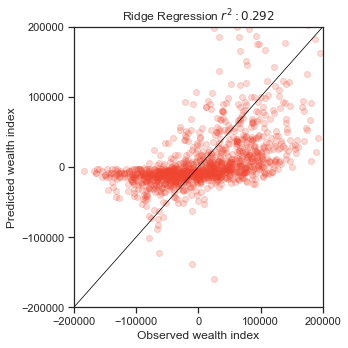

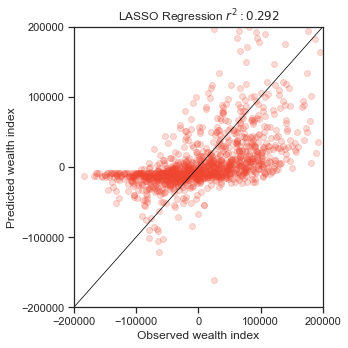

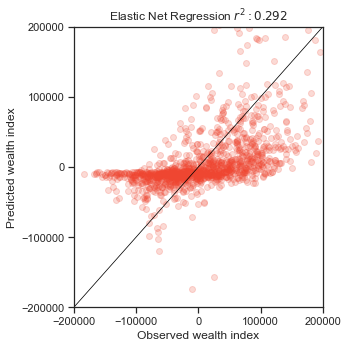

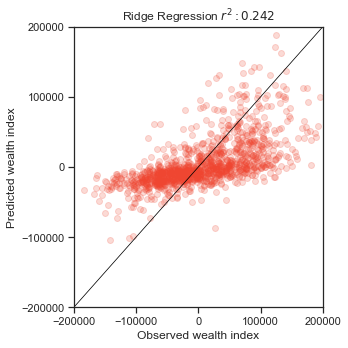

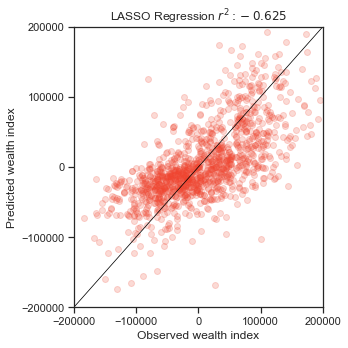

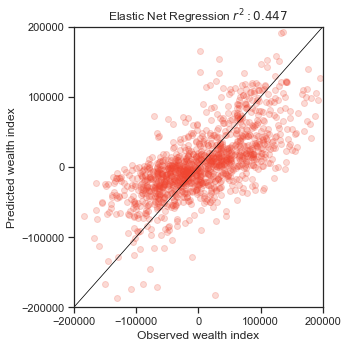

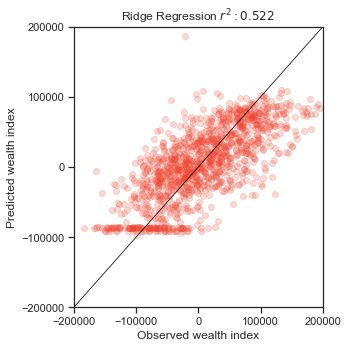

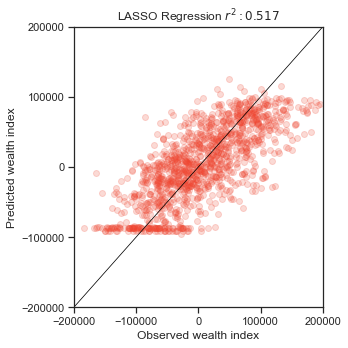

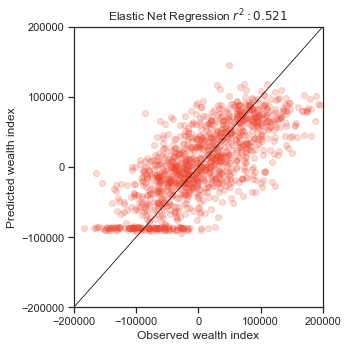

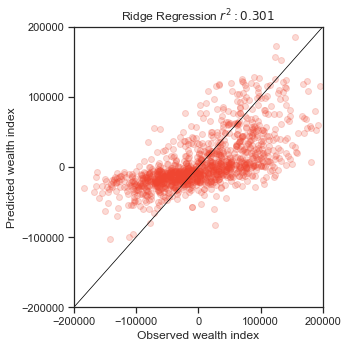

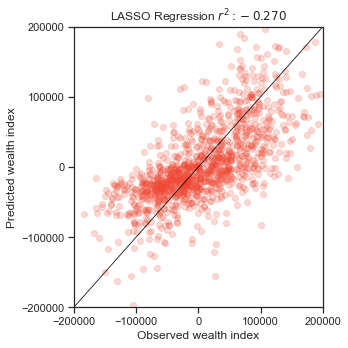

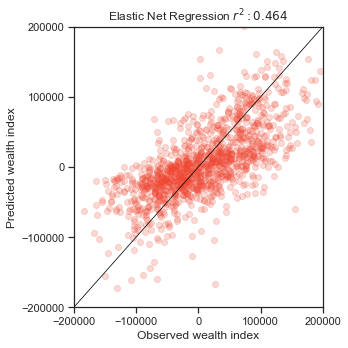

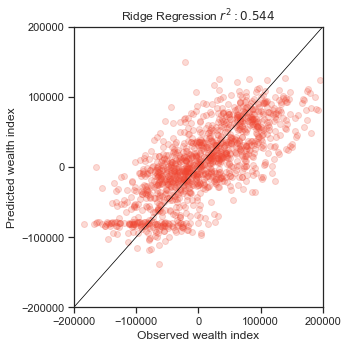

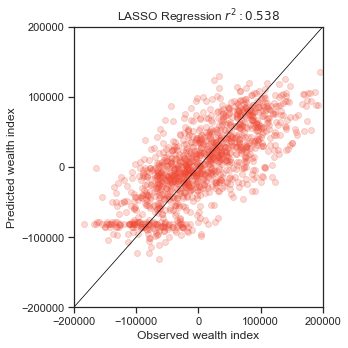

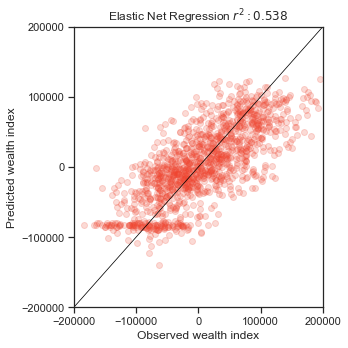

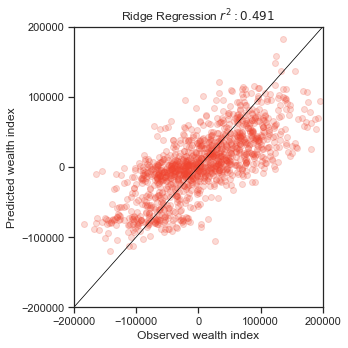

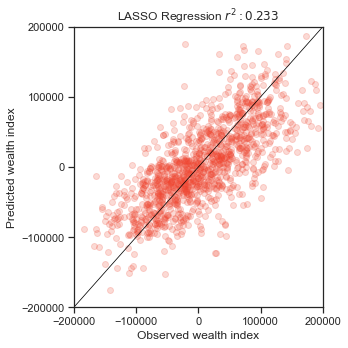

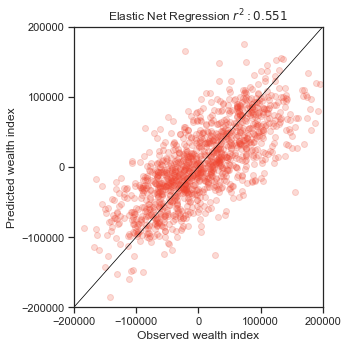

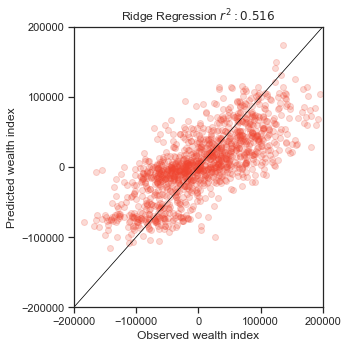

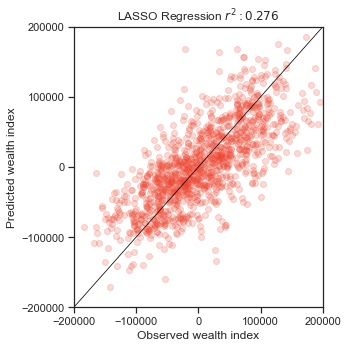

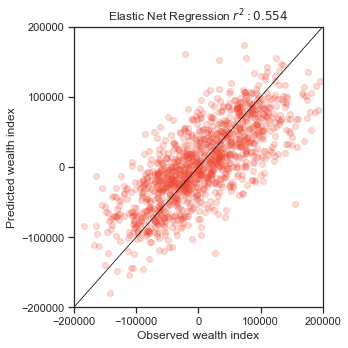

In [8]:
model_types = ['ridge', 'lasso', 'elastic_net']
model_title = {'ridge' : 'Ridge Regression', 'lasso' : 'LASSO Regression', 'elastic_net' : 'Elastic Net Regression'}
refit = 'r2'
n_tests = 100

for ind in range(len(models)):
    X = data[models[ind]]
    y = data['wealth_index']
    
    for model_type in model_types:
        scores = []
        ys = []; ypreds = []

        for _ in range(n_tests):
            model = model_utils.get_model(model_type)
            param_grid = model_utils.get_param_grid(model_type)
            cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid)
            scores.append(nested_scores['test_r2'].mean()); ys.append(y); ypreds.append(y_pred)

        nparr = np.array(scores)
        indice = np.where(nparr == np.amax(nparr))   

        plot_r2(ys[indice[0][0]], ypreds[indice[0][0]], scores[indice[0][0]])
        plt.tight_layout()
        plt.savefig('../images/r2_plots/{}_{}.png'.format(model_type, model_names[ind]), transparent=True, pad_inches=0, dpi=300)

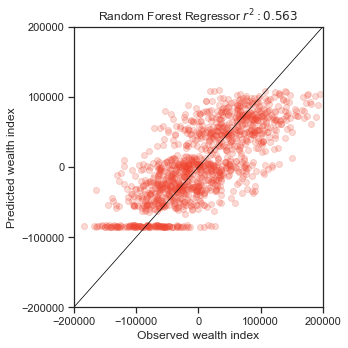

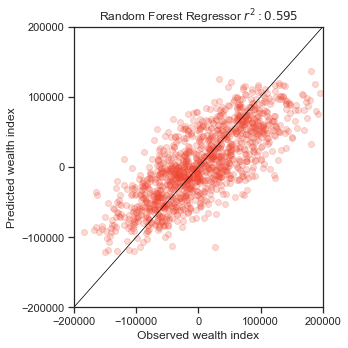

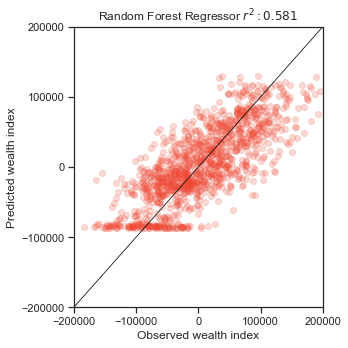

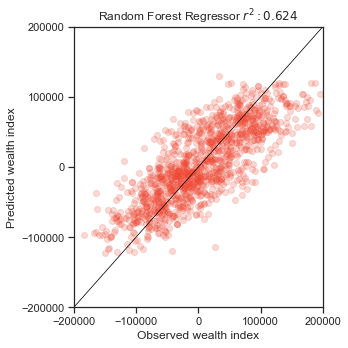

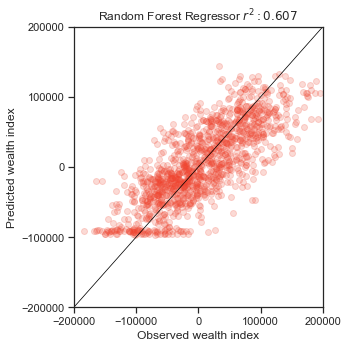

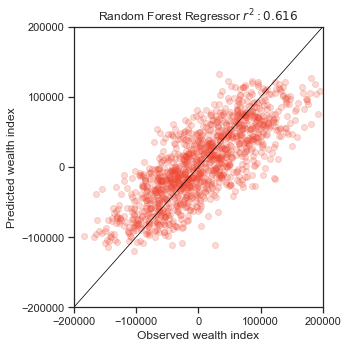

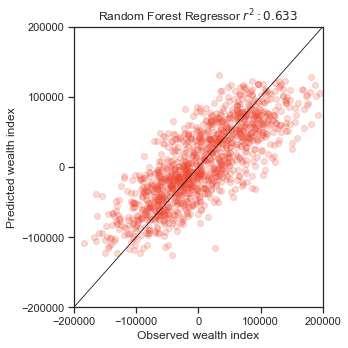

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\Ian Angelo\.conda\envs\modelenv\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\Ian Angelo\.conda\envs\modelenv\lib\site-packages\joblib\externals\loky\process_executor.py", line 566, in run
    self.terminate_broken(bpe)
  File "C:\Users\Ian Angelo\.conda\envs\modelenv\lib\site-packages\joblib\externals\loky\process_executor.py", line 750, in terminate_broken
    self.kill_workers(reason="broken executor")
  File "C:\Users\Ian Angelo\.conda\envs\modelenv\lib\site-packages\joblib\externals\loky\process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "C:\Users\Ian Angelo\.conda\envs\modelenv\lib\site-packages\joblib\externals\loky\backend\utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "C:\Users\Ian Angelo\.conda\envs\modelenv\lib\site-packages\joblib\externals\loky\backend\utils.py", 

In [10]:
model_types = ['random_forest']
model_title = {'ridge' : 'Ridge Regression', 'lasso' : 'LASSO Regression', 'elastic_net' : 'Elastic Net Regression', 'random_forest' : 'Random Forest Regressor'}
refit = 'r2'
n_tests = 5

for ind in range(len(models)):
    X = data[models[ind]]
    y = data['wealth_index']
    
    for model_type in model_types:
        scores = []
        ys = []; ypreds = []

        for _ in range(n_tests):
            model = model_utils.get_model(model_type)
            param_grid = model_utils.get_param_grid(model_type)
            cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid)
            scores.append(nested_scores['test_r2'].mean()); ys.append(y); ypreds.append(y_pred)

        nparr = np.array(scores)
        indice = np.where(nparr == np.amax(nparr))   

        plot_r2(ys[indice[0][0]], ypreds[indice[0][0]], scores[indice[0][0]])
        plt.tight_layout()
        plt.savefig('../images/r2_plots/{}_{}.png'.format(model_type, model_names[ind]), transparent=True, pad_inches=0, dpi=300)

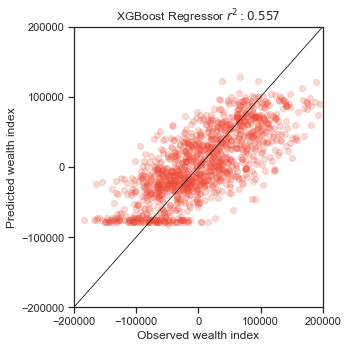

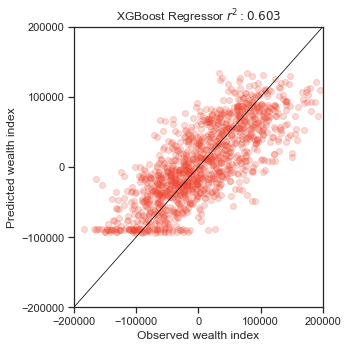

In [8]:
model_types = ['xgboost']
model_title = {'ridge' : 'Ridge Regression', 'lasso' : 'LASSO Regression', 'elastic_net' : 'Elastic Net Regression', 'random_forest' : 'Random Forest Regressor', 'xgboost' : 'XGBoost Regressor'}
refit = 'r2'
n_tests = 5

for ind in range(len(models_without_osm)):
    X = data[models_without_osm[ind]]
    y = data['wealth_index']
    
    for model_type in model_types:
        scores = []
        ys = []; ypreds = []

        for _ in range(n_tests):
            model = model_utils.get_model(model_type)
            param_grid = model_utils.get_param_grid(model_type)
            cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid)
            scores.append(nested_scores['test_r2'].mean()); ys.append(y); ypreds.append(y_pred)

        nparr = np.array(scores)
        indice = np.where(nparr == np.amax(nparr))   

        plot_r2(ys[indice[0][0]], ypreds[indice[0][0]], scores[indice[0][0]])
        plt.tight_layout()
        plt.savefig('../images/r2_plots/{}_{}.png'.format(model_type, models_without_osm_names[ind]), transparent=True, pad_inches=0, dpi=300)

In [10]:
model_types = ['xgboost']
model_title = {'ridge' : 'Ridge Regression', 'lasso' : 'LASSO Regression', 'elastic_net' : 'Elastic Net Regression', 'random_forest' : 'Random Forest Regressor', 'xgboost' : 'XGBoost Regressor'}
refit = 'r2'
n_tests = 5

for ind in range(len(models_with_osm)):
    X = data[models_with_osm[ind]]
    y = data['wealth_index']
    
    for model_type in model_types:
        scores = []
        ys = []; ypreds = []

        for _ in range(n_tests):
            model = model_utils.get_model(model_type)
            param_grid = model_utils.get_param_grid(model_type)
            cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid)
            scores.append(nested_scores['test_r2'].mean()); ys.append(y); ypreds.append(y_pred)

        nparr = np.array(scores)
        indice = np.where(nparr == np.amax(nparr))   

        plot_r2(ys[indice[0][0]], ypreds[indice[0][0]], scores[indice[0][0]])
        plt.tight_layout()
        plt.savefig('../images/r2_plots/{}_{}.png'.format(model_type, models_with_osm_names[ind]), transparent=True, pad_inches=0, dpi=300)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [11]:
X = data[feature_cols_fixednet + feature_cols_mobilenet + osm_cols + feature_cols_nightlights]
y = data['wealth_index']
model_type = 'random_forest'

model = model_utils.get_model(model_type)
param_grid = model_utils.get_param_grid(model_type)
cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid)

cv.fit(X, y)
print('Best Estimator: {}'.format(cv.best_estimator_))
model_utils.random_forest_feature_importance(cv, X, y)

Best Estimator: Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=9, min_samples_split=9,
                                       n_estimators=1863, n_jobs=-1,
                                       random_state=42))])


AttributeError: module 'model_utils' has no attribute 'random_forest_feature_importance'

In [ ]:
X = data[osm_cols + feature_cols_nightlights]
y = data['wealth_index']
model_type = 'random_forest'

model = model_utils.get_model(model_type)
param_grid = model_utils.get_param_grid(model_type)
cv2, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid)

cv2.fit(X, y)
print('Best Estimator: {}'.format(cv2.best_estimator_))
model_utils.random_forest_feature_importance(cv2, X, y)